In [ ]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 4

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataset/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8983 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [6]:
len(dataset)

281

In [7]:
32*281

8992

In [8]:
for img_batch, lbl_batch in dataset.take(1):
  print(img_batch.shape)
  print(lbl_batch.numpy())

(32, 256, 256, 3)
[0 0 2 4 5 4 2 1 2 1 0 5 3 5 2 1 1 2 0 2 5 3 4 2 2 5 2 1 5 5 4 0]


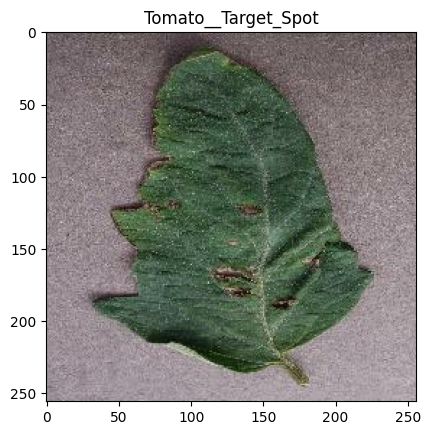

In [9]:
for img_batch, lbl_batch in dataset.take(1):
  plt.imshow(img_batch[0].numpy().astype('uint8'))
  plt.title(class_names[lbl_batch[0]])

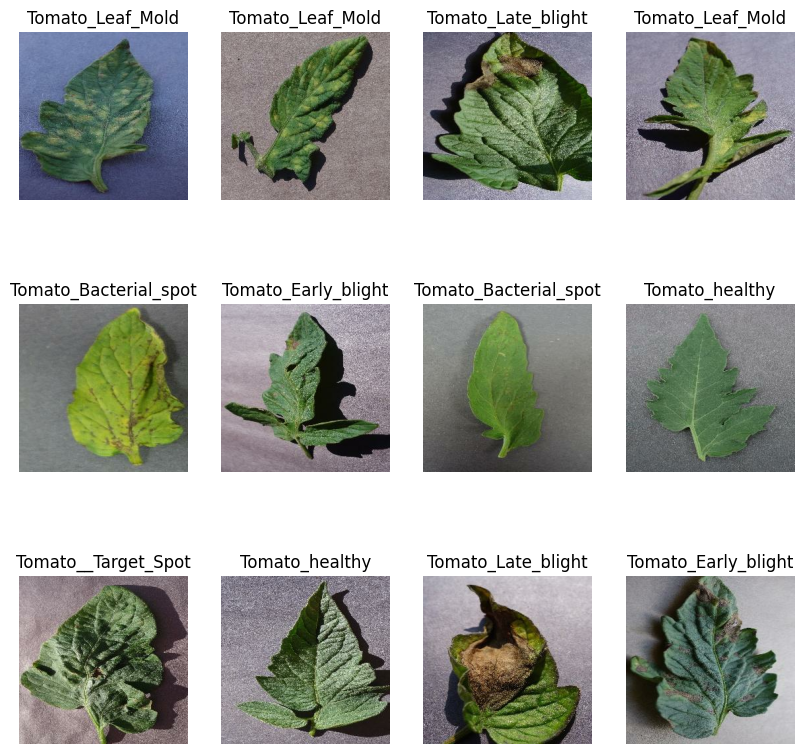

In [10]:
plt.figure(figsize = (10, 10))

for img_batch, lbl_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(img_batch[i].numpy().astype('uint8'))
    plt.title(class_names[lbl_batch[i]])
    plt.axis('off')

In [11]:
train_size = 0.8
len(dataset)*train_size

224.8

In [12]:
train_dataset = dataset.take(224)
len(train_dataset)

224

In [13]:
test_dataset = dataset.skip(224)
len(test_dataset)

57

In [14]:
validation_size = 0.1
len(dataset)*validation_size

28.1

In [15]:
validation_size = test_dataset.take(28)
len(validation_size)

28

In [16]:
test_dataset = test_dataset.skip(28)
len(test_dataset)

29

In [17]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  dataset_size = len(dataset)

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_dataset = dataset.take(train_size)

  validation_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size).take(val_size)

  return train_dataset, validation_dataset, test_dataset


In [18]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [19]:
len(train_dataset)

224

In [20]:
len(validation_dataset)

28

In [21]:
len(test_dataset)

28

In [22]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
counts = {
    "Tomato_Bacterial_spot": 2127,
    "Tomato_Late_blight": 1909,
    "Tomato_healthy": 1591,
    "Tomato__Target_Spot": 1404,
    "Tomato_Early_blight": 1000,
    "Tomato_Leaf_Mold": 952
}

total = sum(counts.values())

class_weights = {}

for idx, (cls, count) in enumerate(counts.items()):
    class_weights[idx] = total / (len(counts) * count)

class_weights


{0: 0.703886538160163,
 1: 0.784267504801816,
 2: 0.9410224177666038,
 3: 1.066358024691358,
 4: 1.4971666666666668,
 5: 1.5726540616246498}

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
no_of_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_of_classes, activation='softmax')
])

model.build(input_shape = input_shape)

C:\Users\HP\myworld\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset
)

Epoch 1/4
224/224 ━━━━━━━━━━━━━━━━━━━━ 132s 568ms/step - accuracy: 0.3952 - loss: 1.5414 - val_accuracy: 0.5022 - val_loss: 1.2434
Epoch 2/4
224/224 ━━━━━━━━━━━━━━━━━━━━ 135s 601ms/step - accuracy: 0.6344 - loss: 0.9844 - val_accuracy: 0.6261 - val_loss: 1.0109
Epoch 3/4
224/224 ━━━━━━━━━━━━━━━━━━━━ 119s 532ms/step - accuracy: 0.7368 - loss: 0.7093 - val_accuracy: 0.7801 - val_loss: 0.5790
Epoch 4/4
224/224 ━━━━━━━━━━━━━━━━━━━━ 120s 534ms/step - accuracy: 0.8026 - loss: 0.5360 - val_accuracy: 0.7667 - val_loss: 0.5794
